In [44]:
#single image plot test
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import regionprops
from cellpose import models, plot
import pandas as pd
import seaborn as sns

In [2]:
# Load model (if not already)
model = models.CellposeModel(gpu=True)

In [27]:
rows = []
primary_id = 1
                    
# all_props = {}
def run_cell_analysis(ch1_path, ch4_path, channel_name):
    """
    Performs Cellpose segmentation, feature extraction, and plotting 
    for a single image file.
    """
    print(f"\n--- Analyzing {channel_name} ---")

    global primary_id
    global rows 
    # Load image
    ch1_img = io.imread(ch1_path, as_gray=True)
    ch4_img = io.imread(ch4_path, as_gray=True)

    # Run Cellpose
    masks, flows, styles = model.eval([ch1_img],
                                      diameter=30,
                                      flow_threshold=0.4,
                                      cellprob_threshold=0.0)

    masks = masks[0]  # Unpack from list

    # Measure properties (masks = boundaries of cells) (intensity = mean intensity of cell)
    # props = regionprops(masks, intensity_image=img)
    props = regionprops(masks, intensity_image=ch1_img[:, :])
    ch4_props = regionprops(masks, intensity_image=ch4_img[:, :])
    
    # --- ADD THIS LINE TO UPDATE THE GLOBAL DICTIONARY ---
    # all_props[channel_name] = props

    for p in props:
        mean_gfp = p.mean_intensity
        area = p.area
        rows.append({"primary_id": primary_id, "nucleus_id": p.label, "area_px": area, "mean_gfp": mean_gfp})
    
    for p in ch4_props:
        area = p.area
        rows.append({"primary_id" : primary_id, "nucleus_id": p.label, "area_px": area, "mean_s647": mean_s647})

    
    rows.append({
            # "file": file_name,
            "primary_id": primary_id,
            "cell_id": p.label, # Use the label to link the two
            "area_px": area,
            "mean_gfp": p_gfp.mean_intensity,
            "mean_s647": p_s647.mean_intensity # Now correctly added!
        })
    
    primary_id += 1
    
    # cell_values = [{'label': p.label, 'area': p.area, 'mean_intensity': p.mean_intensity} for p in props]

    # # Convert to arrays
    # labels = [c['label'] for c in cell_values]
    # areas = [c['area'] for c in cell_values]
    # mean_intensities = [c['mean_intensity'] for c in cell_values]
    
    # Check if any cells were found before plotting
    # if not labels:
    #     print(f"No cells found in {channel_name}. Skipping plots.")
    #     return

    #Load CH4 image (for intensity)
    # ch4_img_data = io.imread(CH4, as_gray=True)
    
    # #Run regionprops using the CH2 mask array and the CH4 intensity image
    # ch4_signal_on_ch2_masks = regionprops(ch2_mask_array, intensity_image=ch4_img_data)

    # ch4_mean_intensity_data = []
    # for p in ch4_signal_on_ch2_masks:
    #     ch4_mean_intensity_data.append(p.mean_intensity)

    df = pd.DataFrame(rows)


In [38]:
import os # Make sure this import is in an earlier cell!
import pandas as pd
# ... other imports (io, regionprops, model)

# INITIALIZATION (MUST BE RUN BEFORE THE FUNCTION IS CALLED)
rows = []
primary_id = 1
                    
def run_cell_analysis(ch1_path, ch4_path):
    """
    Performs Cellpose segmentation and feature extraction for a single image pair.
    The data is appended to the global 'rows' list.
    """
    print(f"\n--- Analyzing file: {os.path.basename(ch1_path)} ---")

    global primary_id
    global rows 
    
    # 1. Load Images (as 2D grayscale)
    ch1_img = io.imread(ch1_path, as_gray=True)
    ch4_img = io.imread(ch4_path, as_gray=True)

    # 2. Run Cellpose (on the ch1/GFP channel)
    masks, flows, styles = model.eval([ch1_img],
                                      diameter=30,
                                      flow_threshold=0.4,
                                      cellprob_threshold=0.0)
    masks = masks[0]  # Unpack from list

    # 3. Measure Properties for BOTH channels using the SAME masks
    # The redundant [:, :] slicing is removed for cleaner code.
    props = regionprops(masks, intensity_image=ch1_img)
    ch4_props = regionprops(masks, intensity_image=ch4_img)
    
    # Get File Name (for tracking)
    file_name = os.path.splitext(os.path.basename(ch1_path))[0]

    # 4. COMBINE DATA INTO ONE ROW PER CELL (The main fix)
    # The 'props' and 'ch4_props' lists are guaranteed to be in the same order 
    # and correspond to the same labels, so we use zip().
    for p_gfp, p_s647 in zip(props, ch4_props):
        rows.append({
            "file": file_name,
            "primary_id": primary_id,
            "nucleus_id": p_gfp.label,
            "area_px": p_gfp.area,
            "mean_gfp": p_gfp.mean_intensity,
            "mean_s647": p_s647.mean_intensity # Both intensities are now in one row
        })
    
    primary_id += 1
    
    # Do NOT create the DataFrame inside the function if you are looping over files.
    # df = pd.DataFrame(rows) # <-- DELETE THIS LINE

In [39]:
# --- Execute the function for both channels ---
# 1. Run analysis for CH2
CH2 = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/S+B+_w1/W001/P00001/HM_W001_P00001_CH2.tif"
CH4 = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/S+B+_w1/W001/P00001/HM_W001_P00001_CH4.tif"

run_cell_analysis(CH2, CH4)
# ch2_props = all_props['CH2']


--- Analyzing file: HM_W001_P00001_CH2.tif ---


In [40]:
df = pd.DataFrame(rows)
df

,file,primary_id,nucleus_id,area_px,mean_gfp,mean_s647
0,HM_W001_P00001_CH2,1,1,194.0,0.092726,0.020584
1,HM_W001_P00001_CH2,1,2,75.0,0.067257,0.015759
2,HM_W001_P00001_CH2,1,3,309.0,0.072253,0.012537
3,HM_W001_P00001_CH2,1,4,87.0,0.081166,0.016023
4,HM_W001_P00001_CH2,1,5,173.0,0.114247,0.023638
...,...,...,...,...,...,...
167,HM_W001_P00001_CH2,1,168,189.0,0.083289,0.027152
168,HM_W001_P00001_CH2,1,169,132.0,0.184695,0.018525
169,HM_W001_P00001_CH2,1,170,104.0,0.075667,0.016988
170,HM_W001_P00001_CH2,1,171,98.0,0.058371,0.014350


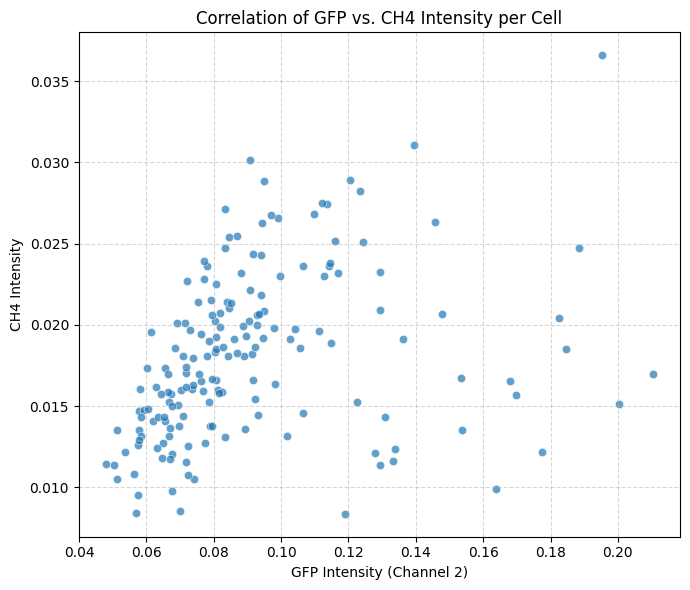

In [42]:
# Plot: Scatter of Area vs Mean Intensity

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x='mean_gfp',
    y='mean_s647',
    alpha=0.7
)

# Add informative labels and title
plt.xlabel("GFP Intensity (Channel 2)")
plt.ylabel("CH4 Intensity")
plt.title("Correlation of GFP vs. CH4 Intensity per Cell")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Save mask
#mask_path = save_folder / f"{all_files[i].stem}_mask.tif"
mask_path = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/cellpose" / f"mask.tif"
io.imsave(mask_path, masks[0])

In [ ]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0])
plt.tight_layout()
plt.show()